# Fast Food Marketing Campaign Effectiveness A/B Test

## Scenario
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

## Goal
Evaluate A/B testing results and decide which marketing strategy works the best. 

## Metrics

Invariants (metrics that are not affected by the experiment): `MarketID`, `MarketSize`, `AgeOfStore`, `week` are the stable features that are not affected by the experiment.

Unit of Diversion: `LocationID` as the experimental promotions were assigned randomly on the location level.

Unit of Analysis: `SalesInThousands`, which are aggregated by week. 

The latter is chosen as our target metric, because it:
- is quantifiable and shows the variance over the weeks when promotional campaigns run (objectivity)
- captures the business performance that can be attributed to different marketing stategies (effectiveness)

## Assumptions

This experiment does not include the control group, where no promotions were tested; thus we can either treat all three promotions groups as independent samples and compare the treatment effect between them; or we can randomly select average promotion sample size (n=183), and use it as a neutral comparison baseline, as it includes all three promotions.

## Outline of analysis

1. Exploratory data analysis: understanding the dataset and designing the A/B test strategy
2. Comparison and statistical tests to show variances between units of measure (Calculation)
3. Decision and recommendations
4. Further improvements and alternatives

### Note

This analysis is supplemented by additional Google Looker dashboard which can be accessed [here](https://lookerstudio.google.com/reporting/cee12c7a-1122-4419-be38-f3d9e4716ac2).

# Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
import scipy.stats as stats

In [2]:
marketing = pd.read_csv('datasets/WA_Marketing-Campaign.csv')
marketing.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [3]:
print(f'The observations of the dataframe: {marketing.shape[0]}')
print(f'The features of the dataframe: {marketing.shape[1]}')
print('\n')
print('::: Dataframe features overview :::')
print('\n')
marketing.info()


The observations of the dataframe: 548
The features of the dataframe: 7


::: Dataframe features overview :::


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [4]:
print(f"The experiment was run in {marketing['MarketID'].value_counts().count()} different markets")
print('\n')
medium = marketing['MarketSize'].value_counts().iloc[0]
large = marketing['MarketSize'].value_counts().iloc[1]
small = marketing['MarketSize'].value_counts().iloc[2]

print(f"There are {small} observations from small markets")
print(f"There are {medium} observations from medium markets")
print(f"There are {large} observations from large markets")
print('\n')

med_sales = marketing.loc[marketing['MarketSize'] == 'Medium']
med_sales['SalesInThousands'].mean()
lar_sales = marketing.loc[marketing['MarketSize'] == 'Large']
lar_sales['SalesInThousands'].mean()
sml_sales = marketing.loc[marketing['MarketSize'] == 'Small']
sml_sales['SalesInThousands'].mean()

print(f"The average weekly sales in small markets: {sml_sales['SalesInThousands'].mean().round(2)}; total: {sml_sales['SalesInThousands'].sum().round(2)}")
print(f"The average weekly sales in medium markets: {med_sales['SalesInThousands'].mean().round(2)}; total: {med_sales['SalesInThousands'].sum().round(2)}")
print(f"The average weekly sales in large markets: {lar_sales['SalesInThousands'].mean().round(2)}; total: {lar_sales['SalesInThousands'].sum().round(2)}")


The experiment was run in 10 different markets


There are 60 observations from small markets
There are 320 observations from medium markets
There are 168 observations from large markets


The average weekly sales in small markets: 57.41; total: 3444.56
The average weekly sales in medium markets: 43.99; total: 14075.31
The average weekly sales in large markets: 70.12; total: 11779.61


In [5]:
marketing[['AgeOfStore', 'SalesInThousands']].describe().round(2)

,AgeOfStore,SalesInThousands
count,548.00,548.00
mean,8.50,53.47
std,6.64,16.76
min,1.00,17.34
25%,4.00,42.54
50%,7.00,50.20
75%,12.00,60.48
max,28.00,99.65


### Evaluation

__Null values__: the dataframe shape (observations) is equal to non-null counts in each feature, indicating that we havo no missing values

__Assumed duplicates__: we expect duplicate values in `MarketSize`, `AgeOfStore`, `Promotion`, `week`, `MarketID`, `LocationID` features – each of the latter appears four times as data is aggregated on weekly basis for 4 weeks. However, `SalesInThousands` values are assumed unique and might be duplicates only coincidentally. 

__Markets__: We see that the majority of information is gathered in Medium-sized markets, but the average weekly sales were the lowest here; due to the largest number of markets, we see their total sales being the highest.

__Summary: metric of interest__: The average weekly sales is around $53.47K, with values ranging from 17.34K to 99.65K, and standard deviation of 16.76K.


In the next steps, we'll look more closely at different samples of promotional campaigns and evaluate them against the total population of experiment.
- separate sample dataframes
- plots
- t-tests of metric variability

In [6]:
promo_1 = marketing[(marketing['Promotion'] == 1)]
promo_2 = marketing[(marketing['Promotion'] == 2)]
promo_3 = marketing[(marketing['Promotion'] == 3)]

mu_total = marketing['SalesInThousands'].mean().round(2)

In [7]:
def outlier_detection(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Looks for outliers in a specified column
    using IQR method and removes observations from dataframe
    Args: 
      df (pd.DataFrame): original dataframe
      col (str): column name in the dataframe
    Returns:
      pd.DataFrame: cleaned dataframe 
    """
    first_q = np.percentile(df[col], 25)
    third_q = np.percentile(df[col], 75)
    IQR = third_q - first_q
    lower = first_q - 1.5 * IQR
    upper = third_q + 1.5 * IQR
    updated_df = df[(df[col] > lower) & 
          (df[col] < upper)]
    return updated_df

In [8]:
promo_1 = outlier_detection(promo_1, 'SalesInThousands')
promo_2 = outlier_detection(promo_2, 'SalesInThousands')
promo_3 = outlier_detection(promo_3, 'SalesInThousands')

m_updated = pd.concat([promo_1, promo_2, promo_3])

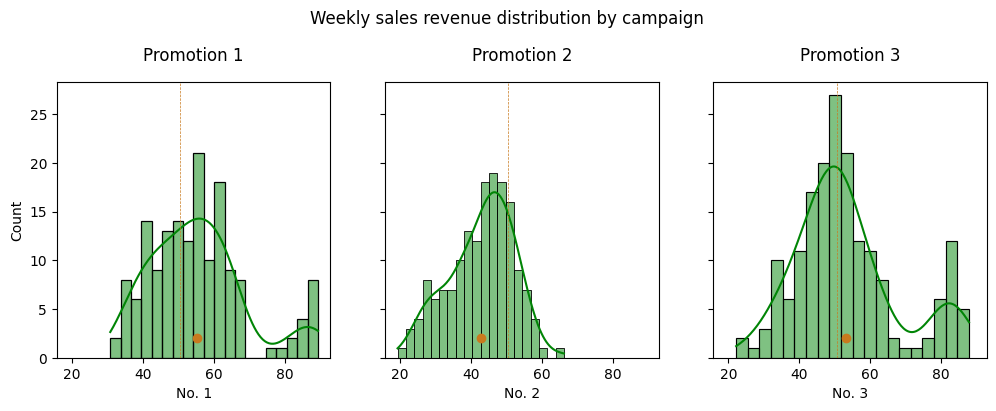

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
fig.suptitle('Weekly sales revenue distribution by campaign')
fig.subplots_adjust(top=0.8)


# Promotion 1
sns.histplot(promo_1['SalesInThousands'], ax=axs[0], bins=20, kde=True, color='#018506')
axs[0].scatter(promo_1['SalesInThousands'].mean(), 2, color = '#c97a1e')
axs[0].set_title('Promotion 1', pad=15)
axs[0].set(ylabel='Count')
axs[0].set(xlabel='No. 1')

# Promotion 2
sns.histplot(promo_2['SalesInThousands'], ax=axs[1], bins=20, kde=True, color='#018506')
axs[1].scatter(promo_2['SalesInThousands'].mean(), 2, color = '#c97a1e')
axs[1].set_title('Promotion 2', pad=15)
axs[1].set(ylabel='Count')
axs[1].set(xlabel='No. 2')

# Promotion 3
sns.histplot(promo_3['SalesInThousands'], ax=axs[2], bins=20, kde=True, color='#018506')
axs[2].scatter(promo_3['SalesInThousands'].mean(), 2, color = '#c97a1e')
axs[2].set_title('Promotion 3', pad=15)
axs[2].set(ylabel='Count')
axs[2].set(xlabel='No. 3')

for ax in axs:
    spec = ax.get_title().split(' = ')[0]
    data = m_updated['SalesInThousands']
    ax.axvline(x=data.mean(), color = '#c97a1e', ls='--', lw=.5)


In [10]:
print(f"The data in first campaign group is from {promo_1['MarketID'].value_counts().count()} markets")
print(f"The data in second campaign group is from {promo_2['MarketID'].value_counts().count()} markets")
print(f"The data in third campaign group is from {promo_3['MarketID'].value_counts().count()} markets")
print('\n')
print(f"The size of Promotion 1 group: {promo_1.shape[0]}")
print(f"The size of Promotion 2 group: {promo_2.shape[0]}")
print(f"The size of Promotion 3 group: {promo_3.shape[0]}")

The data in first campaign group is from 10 markets
The data in second campaign group is from 9 markets
The data in third campaign group is from 10 markets


The size of Promotion 1 group: 160
The size of Promotion 2 group: 164
The size of Promotion 3 group: 178


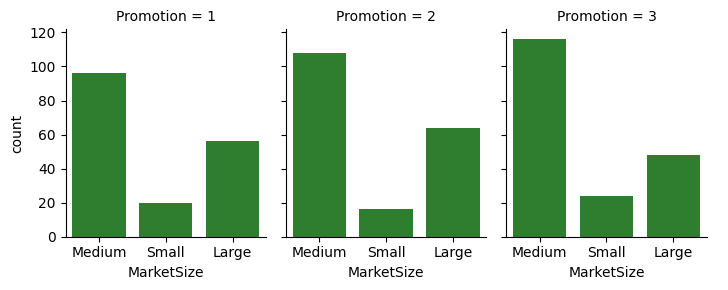

In [11]:
sns.catplot(
    data=marketing, x="MarketSize", col="Promotion",
    kind="count", height=3, aspect=.8, color='forestgreen', sharex=True, sharey=True,
);


We can see that in all cases – in total also – data follows a bimodal distribution, with the majority of data concentrated around 50K, and a slight increase in the upper bound (80, 100). 

We can also see – so far, at the high-level only – that the mean weekly sales value is lower than total average in the experiment group 2, while in the group 1 and 3 the average is higher than total average.

Approximately, we see that experiment groups were selected on equal proportions.

## Experiment analysis

For this analysis, we conduct three hypothesis tests, each for one Promotion campaign sample. We will divide the population in two groups, one containing the Promotion in question, and other the remaining two groups. We then evaluate means, with Null hypothesis stating the equality of means in two groups, under alpha = 0.05

### Promotion 1

In [12]:
prom_1 = m_updated.SalesInThousands[(m_updated.Promotion==1)]
prom_2_3 = m_updated.SalesInThousands[(m_updated.Promotion==2) | (m_updated.Promotion==3)]

In [13]:
mu_p1 = prom_1.mean()
mu_p23 = prom_2_3.mean()

diff = mu_p1 - mu_p23

print(f'The estimated average weekly sales difference: {diff}')

The estimated average weekly sales difference: 7.030450657894733


In [14]:
t = stats.ttest_ind(prom_1, prom_2_3)
t_stat_p1 = t[0]
p_val_p1 = t[1]
df_p1 = t.df
df_p1

print(f'The t-test results:')
print('\n')
print(f"T-test statistic: {t_stat_p1}")
print(f"P-value: {p_val_p1}")
print(f"Degrees of freedom: {df_p1}")

The t-test results:


T-test statistic: 5.465151710223118
P-value: 7.309376875919368e-08
Degrees of freedom: 500.0


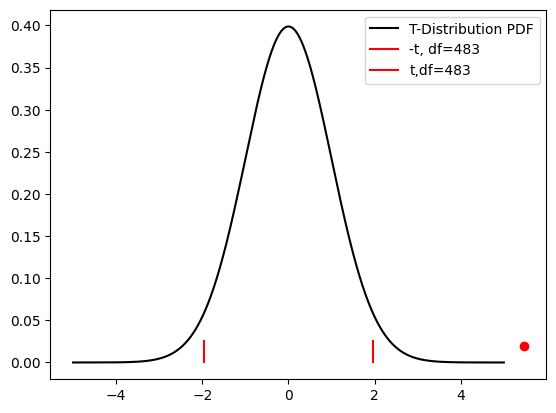

In [15]:
alpha = 0.05
ntails = 2
tcrit = abs(stats.t.ppf(alpha/ntails, df_p1))

plt.figure()
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, stats.t.pdf(xs, df_p1), 'k', label="T-Distribution PDF")

critline = np.linspace(0, alpha/ntails)
xs_1 = len(critline) * [-tcrit]
xs_2 = len(critline) * [tcrit]
plt.plot(xs_1, critline, 'r', label='-t, df=483')
plt.plot(xs_2, critline, 'r', label='t,df=483')
plt.plot(t_stat_p1,0.02,'ro')
plt.legend();

In [16]:
p1_t_ci = t.confidence_interval(confidence_level=0.95)

print(f"The difference confidence interval lower bound = {p1_t_ci[0]}")
print(f"The difference confidence interval upper bound = {p1_t_ci[1]}")

The difference confidence interval lower bound = 4.503006479526773
The difference confidence interval upper bound = 9.557894836262692


In [17]:
experiment_p1_ci = sms.zconfint(prom_1, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)
print(f"The promotion group confidence interval lower bound = {experiment_p1_ci[0]}")
print(f"The promotion group confidence interval upper bound = {experiment_p1_ci[1]}")

The promotion group confidence interval lower bound = 53.23872787051273
The promotion group confidence interval upper bound = 57.451647129487256


With p < 0.05 and t-statistic exceeding the t-distribution range, we can conclude, that it is highly unlikely that sample means have occured by chance, leading us to reject the Null hyptohesis. The difference between samples is statistically significant, given that the mean difference 6.29K has a confidence interval of (4.503; 9.577) and does not include 0.

<Figure size 800x400 with 0 Axes>

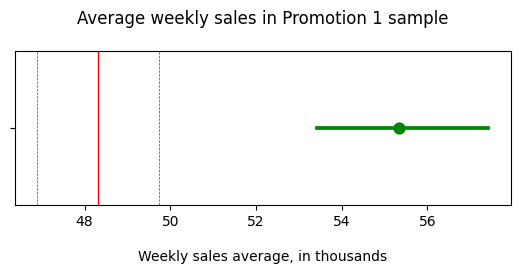

In [18]:
control_ci = sms.zconfint(prom_2_3, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)

fig = plt.figure(figsize=(8, 4))
plt.figure().set_figheight(2)
sns.pointplot(x=prom_1, estimator='mean', color='#018506')
plt.axvline(x=prom_2_3.mean(), c='r', ls='-', lw=1, color = '#c97a1e')
plt.axvline(x=control_ci[0], c='r', ls='--', lw=.5, color = '#c97a1e')
plt.axvline(x=control_ci[1], c='r', ls='--', lw=.5, color = '#c97a1e')
plt.title('Average weekly sales in Promotion 1 sample', pad=20)
plt.xlabel('Weekly sales average, in thousands', labelpad=15);

### Promotion 2

In [19]:
prom_2 = m_updated.SalesInThousands[(m_updated.Promotion==2)]
prom_1_3 = m_updated.SalesInThousands[(m_updated.Promotion==1) | (m_updated.Promotion==3)]

In [20]:
mu_p2 = prom_2.mean()
mu_p13 = prom_1_3.mean()

diff = mu_p2 - mu_p13

print(f'The estimated average weekly sales difference: {diff}')

The estimated average weekly sales difference: -11.360973444941543


Notice that the second promotion group actually has a lower average sales revenue than the rest of the groups. We now have to check if that's statistically significant.

In [21]:
t = stats.ttest_ind(prom_2, prom_1_3)
t_stat_p2 = t[0]
p_val_p2 = t[1]
df_p2 = t.df

print(f'The t-test results:')
print('\n')
print(f"T-test statistic: {t_stat_p2}")
print(f"P-value: {p_val_p2}")
print(f"Degrees of freedom: {df_p2}")

The t-test results:


T-test statistic: -9.360674441458224
P-value: 2.683015549057731e-19
Degrees of freedom: 500.0


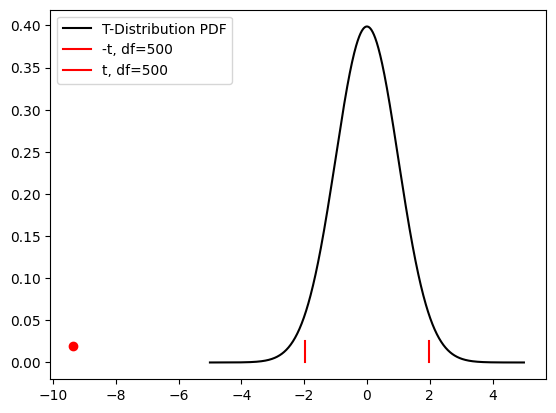

In [22]:
alpha = 0.05
ntails = 2

tcrit = abs(stats.t.ppf(alpha/ntails, df_p2))

plt.figure()
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, stats.t.pdf(xs, df_p2), 'k', label="T-Distribution PDF")

critline = np.linspace(0, alpha/ntails)
xs_1 = len(critline) * [-tcrit]
xs_2 = len(critline) * [tcrit]
plt.plot(xs_1, critline, 'r', label='-t, df=500')
plt.plot(xs_2, critline, 'r', label='t, df=500')
plt.plot(t_stat_p2,0.02,'ro')
plt.legend();

In [23]:
p2_t_ci = t.confidence_interval(confidence_level=0.95)

print(f"The difference confidence interval lower bound = {p2_t_ci[0]}")
print(f"The difference confidence interval upper bound = {p2_t_ci[1]}")

The difference confidence interval lower bound = -13.74553772391663
The difference confidence interval upper bound = -8.976409165966455


In [24]:
experiment_p2_ci = sms.zconfint(prom_2, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)
print(f"The promotion group confidence interval lower bound = {experiment_p2_ci[0]}")
print(f"The promotion group confidence interval upper bound = {experiment_p2_ci[1]}")

The promotion group confidence interval lower bound = 41.51985597526553
The promotion group confidence interval upper bound = 44.29233914668569


With p < 0.05 and t-statistic exceeding the t-distribution range, we can conclude, that it is highly unlikely that sample means have occured by chance, leading us to reject the Null hyptohesis. The difference between samples is statistically significant, given that the mean difference -11.36K has a confidence interval of (-13.75; -8.976) and does not include 0. However, in this case, the difference is negative, suggesting that results in second promotional group are worse, compared to the remaining ones.

<Figure size 800x400 with 0 Axes>

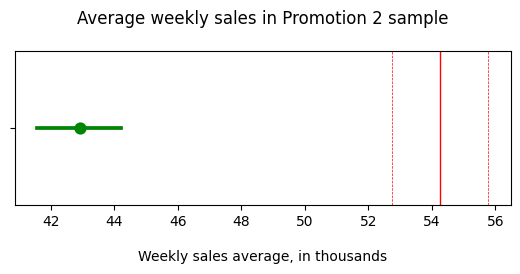

In [25]:
control_ci = sms.zconfint(prom_1_3, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)

fig = plt.figure(figsize=(8, 4))
plt.figure().set_figheight(2)
sns.pointplot(x=prom_2, estimator='mean', color='#018506')
plt.axvline(x=prom_1_3.mean(), c='r', ls='-', lw=1, color = '#c97a1e')
plt.axvline(x=control_ci[0], c='r', ls='--', lw=.5, color = '#c97a1e')
plt.axvline(x=control_ci[1], c='r', ls='--', lw=.5, color = '#c97a1e')
plt.title('Average weekly sales in Promotion 2 sample', pad=20)
plt.xlabel('Weekly sales average, in thousands', labelpad=15);

### Promotion 3

In [26]:
prom_3 = m_updated.SalesInThousands[(m_updated.Promotion==3)]
prom_1_2 = m_updated.SalesInThousands[(m_updated.Promotion==1) | (m_updated.Promotion==2)]

In [27]:
mu_p3 = prom_3.mean()
mu_p12 = prom_1_2.mean()

diff = mu_p3 - mu_p12

print(f'The estimated average weekly sales difference: {diff}')

The estimated average weekly sales difference: 4.249119503398539


In [28]:
t = stats.ttest_ind(prom_3, prom_1_2)
t_stat_p3 = t[0]
p_val_p3 = t[1]
df_p3 = t.df

print(f'The t-test results:')
print('\n')
print(f"T-test statistic: {t_stat_p3}")
print(f"P-value: {p_val_p3}")
print(f"Degrees of freedom: {df_p3}")

The t-test results:


T-test statistic: 3.3303735473985014
P-value: 0.0009313931627419375
Degrees of freedom: 500.0


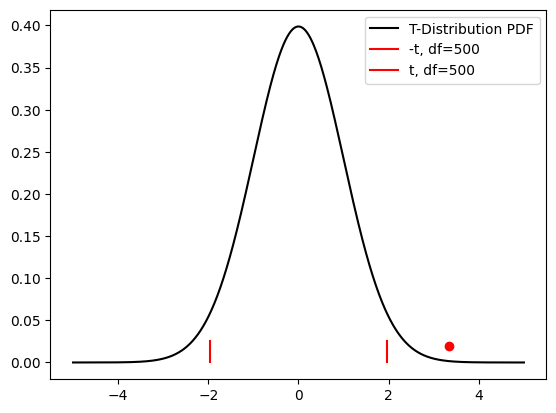

In [29]:
alpha = 0.05
ntails = 2

tcrit = abs(stats.t.ppf(alpha/ntails, df_p3))

plt.figure()
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, stats.t.pdf(xs, df_p3), 'k', label="T-Distribution PDF")

critline = np.linspace(0, alpha/ntails)
xs_1 = len(critline) * [-tcrit]
xs_2 = len(critline) * [tcrit]
plt.plot(xs_1, critline, 'r', label='-t, df=500')
plt.plot(xs_2, critline, 'r', label='t, df=500')
plt.plot(t_stat_p3,0.02,'ro')
plt.legend();

In [30]:
p3_t_ci = t.confidence_interval(confidence_level=0.95)

print(f"The difference confidence interval lower bound = {p3_t_ci[0]}")
print(f"The difference confidence interval upper bound = {p3_t_ci[1]}")

The difference confidence interval lower bound = 1.7423948788837489
The difference confidence interval upper bound = 6.7558441279133294


In [31]:
experiment_p3_ci = sms.zconfint(prom_3, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)
print(f"The promotion group confidence interval lower bound = {experiment_p3_ci[0]}")
print(f"The promotion group confidence interval upper bound = {experiment_p3_ci[1]}")

The promotion group confidence interval lower bound = 51.13931426280653
The promotion group confidence interval upper bound = 55.45664079337326


With p < 0.05 and t-statistic exceeding the t-distribution range, we can conclude, that it is highly unlikely that sample means have occured by chance, leading us to reject the Null hyptohesis. The difference between samples is statistically significant, given that the mean difference 4.249K has a confidence interval of (1.742; 6.756) and does not include 0. It has the similar dynamics to the first group, but somewhat a weaker treatment effect (7.03K vs 4.249K). We'll have to investigate those two groups in our final part of analysis to conclude with a recommendation.

<Figure size 1200x600 with 0 Axes>

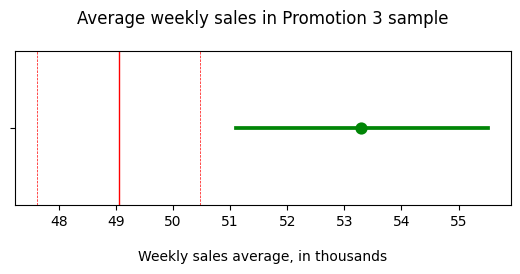

In [32]:
control_ci = sms.zconfint(prom_1_2, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)

fig = plt.figure(figsize=(12, 6))
plt.figure().set_figheight(2)
sns.pointplot(x=prom_3, estimator='mean', color='#018506')
plt.axvline(x=prom_1_2.mean(), c='r', ls='-', lw=1, color = '#c97a1e')
plt.axvline(x=control_ci[0], c='r', ls='--', lw=.5, color = '#c97a1e')
plt.axvline(x=control_ci[1], c='r', ls='--', lw=.5, color = '#c97a1e')
plt.title('Average weekly sales in Promotion 3 sample', pad=20)
plt.xlabel('Weekly sales average, in thousands', labelpad=15);

Text(0.5, 0, '')

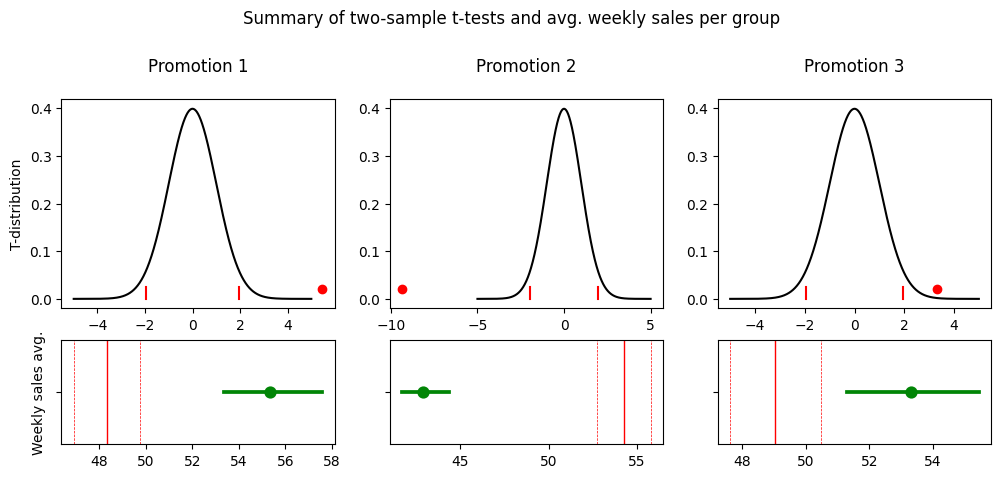

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(12, 5),  gridspec_kw = {'height_ratios':[2, 1]})
fig.suptitle('Summary of two-sample t-tests and avg. weekly sales per group')
fig.subplots_adjust(top=0.8)

alpha = 0.05
ntails = 2

# t1
tcrit = abs(stats.t.ppf(alpha/ntails, df_p1))
xs = np.linspace(-5, 5, 1000)
axs[0, 0].plot(xs, stats.t.pdf(xs, df_p1), 'k', label="T-Distribution PDF")

critline = np.linspace(0, alpha/ntails)
xs_1 = len(critline) * [-tcrit]
xs_2 = len(critline) * [tcrit]
axs[0, 0].plot(xs_1, critline, 'r', label='-t for df=483')
axs[0, 0].plot(xs_2, critline, 'r', label='t for df=483')
axs[0, 0].plot(t_stat_p1,0.02,'ro')
axs[0, 0].set_title('Promotion 1', pad=20)
axs[0, 0].set_ylabel('T-distribution')

# t2
tcrit = abs(stats.t.ppf(alpha/ntails, df_p2))
xs = np.linspace(-5, 5, 1000)
axs[0, 1].plot(xs, stats.t.pdf(xs, df_p2), 'k', label="T-Distribution PDF")

critline = np.linspace(0, alpha/ntails)
xs_1 = len(critline) * [-tcrit]
xs_2 = len(critline) * [tcrit]
axs[0, 1].plot(xs_1, critline, 'r', label='-t for df=500')
axs[0, 1].plot(xs_2, critline, 'r', label='t for df=500')
axs[0, 1].plot(t_stat_p2,0.02,'ro')
axs[0, 1].set_title('Promotion 2', pad=20)

# t3
tcrit = abs(stats.t.ppf(alpha/ntails, df_p3))
xs = np.linspace(-5, 5, 1000)
axs[0, 2].plot(xs, stats.t.pdf(xs, df_p3), 'k', label="T-Distribution PDF")

critline = np.linspace(0, alpha/ntails)
xs_1 = len(critline) * [-tcrit]
xs_2 = len(critline) * [tcrit]
axs[0, 2].plot(xs_1, critline, 'r', label='-t for df=500')
axs[0, 2].plot(xs_2, critline, 'r', label='t for df=500')
axs[0, 2].plot(t_stat_p3,0.02,'ro')
axs[0, 2].set_title('Promotion 3', pad=20)


# s1
control_ci = sms.zconfint(prom_2_3, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)

sns.pointplot(x=prom_1, estimator='mean', ax=axs[1, 0], color='#018506')
axs[1, 0].axvline(x=prom_2_3.mean(), c='r', ls='-', lw=1, color = '#c97a1e')
axs[1, 0].axvline(x=control_ci[0], c='r', ls='--', lw=.5, color = '#c97a1e')
axs[1, 0].axvline(x=control_ci[1], c='r', ls='--', lw=.5, color = '#c97a1e')
axs[1, 0].set_xlabel('')
axs[1, 0].set_ylabel('Weekly sales avg.')

# s2
control_ci = sms.zconfint(prom_1_3, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)

sns.pointplot(x=prom_2, estimator='mean', ax=axs[1, 1], color='#018506')
axs[1, 1].axvline(x=prom_1_3.mean(), c='r', ls='-', lw=1, color = '#c97a1e')
axs[1, 1].axvline(x=control_ci[0], c='r', ls='--', lw=.5, color = '#c97a1e')
axs[1, 1].axvline(x=control_ci[1], c='r', ls='--', lw=.5, color = '#c97a1e')
axs[1, 1].set_xlabel('')

# s3
control_ci = sms.zconfint(prom_1_2, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)

sns.pointplot(x=prom_3, estimator='mean', ax=axs[1, 2], color='#018506')
axs[1, 2].axvline(x=prom_1_2.mean(), c='r', ls='-', lw=1, color = '#c97a1e')
axs[1, 2].axvline(x=control_ci[0], c='r', ls='--', lw=.5, color = '#c97a1e')
axs[1, 2].axvline(x=control_ci[1], c='r', ls='--', lw=.5, color = '#c97a1e')
axs[1, 2].set_xlabel('')

## Additional analysis of Promotion 1 and Promotion 3 groups

The initial analysis shows that the weekly average sales revenues were considerably lower in locations that run the second promotional campaign. Ginven this, we eliminate it from further considerations, and direct our efforts towards the question, if we should proceed with Promotion 1 or Promotion 3. Again, we compare two samples that ran either the first or the third campaigns. We already saw that, on average, Promotion 1 average sales are higher, but we still need to be sure if the differences are statistically valid, thus, we assume, under the Null, that mu_1 = mu_3. 

In [34]:
diff = mu_p1 - mu_p3

print(f'The estimated average weekly sales difference: {diff}')

The estimated average weekly sales difference: 2.0472099719100996


In [35]:
t = stats.ttest_ind(prom_1, prom_3)
t_stat = t[0]
p_val = t[1]
df = t.df

print(f'The t-test results:')
print('\n')
print(f"T-test statistic: {t_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of freedom: {df}")

The t-test results:


T-test statistic: 1.3248315388218805
P-value: 0.18612732505742063
Degrees of freedom: 336.0


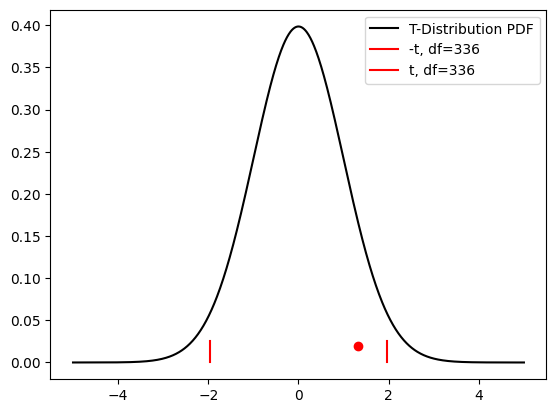

In [36]:
alpha = 0.05
ntails = 2

tcrit = abs(stats.t.ppf(alpha/ntails, df))

plt.figure()
xs = np.linspace(-5, 5, 1000)
plt.plot(xs, stats.t.pdf(xs, df), 'k', label="T-Distribution PDF")

critline = np.linspace(0, alpha/ntails)
xs_1 = len(critline) * [-tcrit]
xs_2 = len(critline) * [tcrit]
plt.plot(xs_1, critline, 'r', label='-t, df=336')
plt.plot(xs_2, critline, 'r', label='t, df=336')
plt.plot(t_stat,0.02,'ro')
plt.legend();

In [37]:
p1_df = pd.Series.to_frame(prom_1, name='promotion1')
p3_df = pd.Series.to_frame(prom_3, name='promotion3')
p1_df= pd.melt(p1_df, value_vars='promotion1')
p3_df= pd.melt(p3_df, value_vars='promotion3')
p1_p3 = pd.concat([p1_df, p3_df])

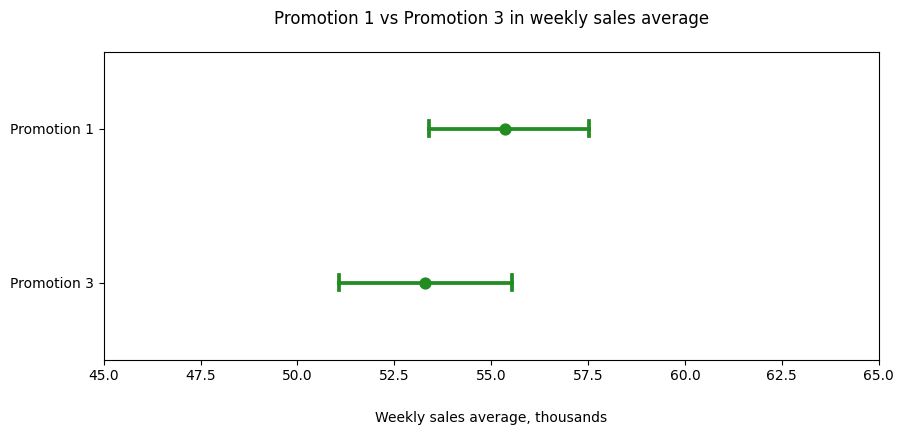

In [38]:
plt.figure(figsize=(10, 4))
sns.pointplot(
    data=p1_p3, x='value', y='variable',
    errorbar=("ci", 95), capsize=.1,
    color="forestgreen", linestyle="none", orient='h'
)
plt.title('Promotion 1 vs Promotion 3 in weekly sales average', pad=20)
plt.ylabel('')
plt.xlabel('Weekly sales average, thousands', labelpad=20)
plt.yticks([0, 1], ['Promotion 1', 'Promotion 3'])
plt.xlim(45, 65);

### Summary

1. The confidence intervals of Promotion 1 and Promotion 3 groups overlap, p-value is greater than the significance level (0.18 > 0.05), and t-test value falls within the distribution range. This suggests that statistically there are no significant differences in weekly average sales between those two groups and we fail to reject the Null.

2. We can confidently conclude that we should not continue with the Promotion 2 as it shows poor performance and it is statistically significant. 

3. To proceed further with the experiment, we first should perform additional analysis of the Promotion 1 and Promotion 3 groups, looking at other significant factors, such as market size, locations or week-over-week dynamics. 

4. We could also consider changing the main metric to median or upper-quartile weekly sales, or calculating comparing cumulative weekly sales place-by-place. This granular approach would prevent Simpson's paradox of the high-level aggregation of data. 

## Appendix: bootstrapping confidence intervals 

Another way to come up with confidence intervals is via bootstrapping techique – a simulation that repeatedly takes observations from a given sample and calculates the mean of the sub-sample. If the initial sample is large enough, the means are expected to be normally distributed. If we assume significance level alpha=0.05, then we cut the 2.5% and 97.5% percentiles of the resulting array of bootstrapped means, treating lowest and highest values as confidence interval bounds. We run this simulation on Promotion 1 and Promotion 3 groups.

In [39]:
def simulation(data: pd.DataFrame, sample_size=50, simulations=5000) -> tuple:
    """
    A bootstrapping simulation that repeatedly resamples original dataset
    and computes confidence intervals at 95% confidence level by cutting
    2.5% of the outer values of the array
    """
    means = np.array([])
    for _ in range(simulations):
        sub_sample = np.random.choice(data, sample_size)
        means = np.append(means, sub_sample.mean())
    means = np.sort(means)
    range_95 = np.array([])
    for i in means:
        if i > np.percentile(means, 2.5) and i < np.percentile(means, 97.5):
            range_95 = np.append(range_95, i)
    ci_lb = range_95.min()
    ci_ub = range_95.max()
    b_mean = range_95.mean()

    return (ci_lb, b_mean, ci_ub)

In [40]:
sim_prom1 = simulation(prom_1)
sim_prom3 = simulation(prom_3)

print(f'::: PROMOTION 1 :::')
print('\n')
print(f"Bootstrapped mean: {sim_prom1[1]}")
print(f"Bootstrapped confidence interval lower bound: {sim_prom1[0]}")
print(f"Bootstrapped confidence interval upper bound: {sim_prom1[2]}")
print('\n')
print(f'::: PROMOTION 3 :::')
print('\n')
print(f"Bootstrapped mean: {sim_prom3[1]}")
print(f"Bootstrapped confidence interval lower bound: {sim_prom3[0]}")
print(f"Bootstrapped confidence interval upper bound: {sim_prom3[2]}")

::: PROMOTION 1 :::


Bootstrapped mean: 55.29134538947368
Bootstrapped confidence interval lower bound: 51.6958
Bootstrapped confidence interval upper bound: 59.06419999999999


::: PROMOTION 3 :::


Bootstrapped mean: 53.25020303157894
Bootstrapped confidence interval lower bound: 49.27839999999999
Bootstrapped confidence interval upper bound: 57.42240000000001


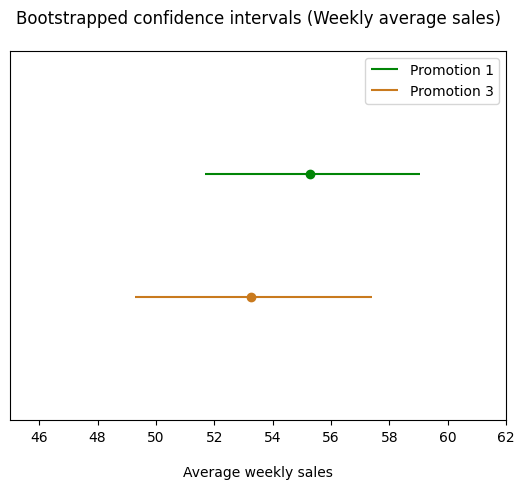

In [41]:
fig, ax = plt.subplots()

ax.hlines(y = 2, xmin = sim_prom1[0], xmax = sim_prom1[2], color = '#018506', linestyle = '-', label='Promotion 1')
ax.hlines(y = 1, xmin = sim_prom3[0], xmax = sim_prom3[2], color = '#c97a1e', linestyle = '-', label='Promotion 3')
ax.scatter(x = sim_prom1[1], y=2, color = '#018506')
ax.scatter(x = sim_prom3[1], y=1, color = '#c97a1e')
ax.set_ylim(0, 3)
ax.set_xlim(45,62)
ax.set_title('Bootstrapped confidence intervals (Weekly average sales)', pad=20)
ax.set_xlabel('Average weekly sales', labelpad=15)
ax.set_yticks([])
plt.legend();

In [42]:
a_ci_p1 = sms.zconfint(prom_1, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)
a_ci_p3 = sms.zconfint(prom_3, value=0, alpha=0.05, alternative='two-sided', usevar='pooled', ddof=1.0)

print(f'::: PROMOTION 1 :::')
print('\n')
print(f"Bootstrapped mean: {sim_prom1[1]}")
print(f"Bootstrapped confidence interval lower bound: {sim_prom1[0]}")
print(f"Bootstrapped confidence interval upper bound: {sim_prom1[2]}")
print('\n')
print(f"Analytical mean: {prom_1.mean()}")
print(f"Analytical confidence interval lower bound: {a_ci_p1[0]}")
print(f"Analytical confidence interval upper bound: {a_ci_p1[1]}")
print('\n')

print(f'::: PROMOTION 3 :::')
print('\n')
print(f"Bootstrapped mean: {sim_prom3[1]}")
print(f"Bootstrapped confidence interval lower bound: {sim_prom3[0]}")
print(f"Bootstrapped confidence interval upper bound: {sim_prom3[2]}")
print('\n')
print(f"Analytical mean: {prom_3.mean()}")
print(f"Analytical confidence interval lower bound: {a_ci_p3[0]}")
print(f"Analytical confidence interval upper bound: {a_ci_p3[1]}")

::: PROMOTION 1 :::


Bootstrapped mean: 55.29134538947368
Bootstrapped confidence interval lower bound: 51.6958
Bootstrapped confidence interval upper bound: 59.06419999999999


Analytical mean: 55.345187499999994
Analytical confidence interval lower bound: 53.23872787051273
Analytical confidence interval upper bound: 57.451647129487256


::: PROMOTION 3 :::


Bootstrapped mean: 53.25020303157894
Bootstrapped confidence interval lower bound: 49.27839999999999
Bootstrapped confidence interval upper bound: 57.42240000000001


Analytical mean: 53.297977528089895
Analytical confidence interval lower bound: 51.13931426280653
Analytical confidence interval upper bound: 55.45664079337326


We see that while simulated confidence intervals allow for wider confidence intervals, the general trend remains the same. Also, both averages overlap, preventing us form making a clear, unambiguous decision.

__Export to CSV for dashboarding__

In [43]:
m_updated.to_csv('marketing_campaigns.csv', index=False)